## RDS data decoding from the PySDR 

In [86]:
import numpy as np
from scipy.signal import resample_poly, firwin, bilinear, lfilter
import matplotlib.pyplot as plt

# Read in signal
x = np.fromfile('fm_rds_250k_1Msamples.iq', dtype=np.complex64)
sample_rate = 250e3
center_freq = 99.5e6

### FM Demodulation, Frequency shift (bringing RDS to 0 Hz) and Filtering

In [87]:
x = 0.5 * np.angle(x[0:-1] * np.conj(x[1:]))

N = len(x)
f_o = -57e3 # amount we need to shift by
t = np.arange(N)/sample_rate # time vector
x = x * np.exp(2j*np.pi*f_o*t) # down shift

taps = firwin(numtaps=101, cutoff=7.5e3, fs=sample_rate)
x = np.convolve(x, taps, 'valid')

### Decimate and resample

Why? - Any time you filter down to a small fraction of your bandwidth it makes sense to decimate. Alway sremember to update the sample rate when performing an operation that changes it 

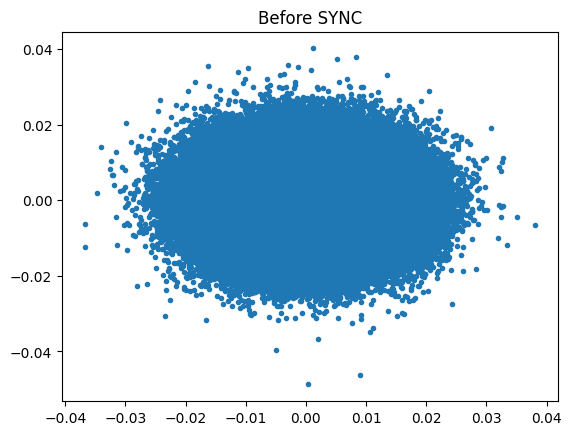

In [88]:
x = x[::10]
sample_rate = 25e3

x = resample_poly(x, 19, 25) # up, down
sample_rate = 19e3

plt.figure(0)
plt.plot(np.real(x), np.imag(x), '.')
plt.title("Before SYNC")
plt.show()

### Time Synchronization

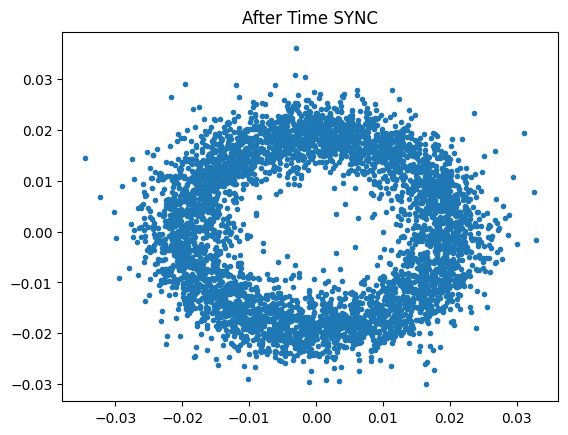

In [89]:
# Symbol sync, using what we did in sync chapter
samples = x # for the sake of matching the sync chapter
samples_interpolated = resample_poly(samples, 32, 1) # we'll use 32 as the interpolation factor, arbitrarily chosen, seems to work better than 16
sps = 16
mu = 0.01 # initial estimate of phase of sample
out = np.zeros(len(samples) + 10, dtype=np.complex64)
out_rail = np.zeros(len(samples) + 10, dtype=np.complex64) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(samples) and i_in+32 < len(samples):
    out[i_out] = samples_interpolated[i_in*32 + int(mu*32)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.01*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
x = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)

plt.figure(0)
plt.plot(np.real(x), np.imag(x), '.')
plt.title("After Time SYNC")
plt.show()

### Fine Frequency Synchronization

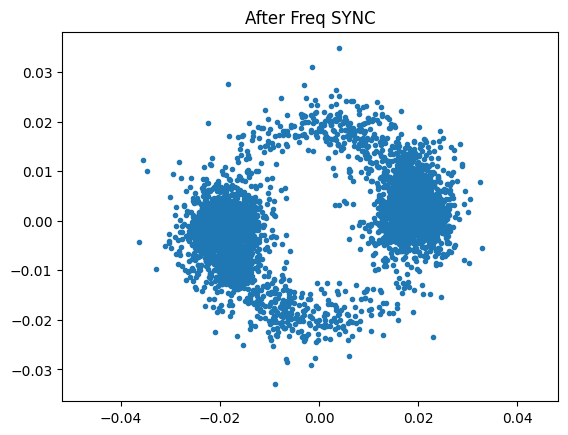

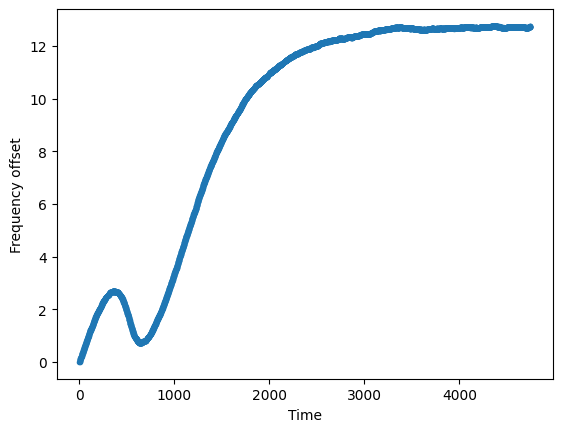

In [90]:
# Fine freq sync
samples = x # for the sake of matching the sync chapter
N = len(samples)
phase = 0
freq = 0
# These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
alpha = 16.0
beta = 0.02
out = np.zeros(N, dtype=np.complex64)
freq_log = []
for i in range(N):
    out[i] = samples[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
    error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)

    # Advance the loop (recalc phase and freq offset)
    freq += (beta * error)
    freq_log.append(freq * sample_rate / (2*np.pi)) # convert from angular velocity to Hz for logging
    phase += freq + (alpha * error)

    # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
    while phase >= 2*np.pi:
        phase -= 2*np.pi
    while phase < 0:
        phase += 2*np.pi
x = out

plt.figure(0)
plt.plot(np.real(x), np.imag(x), '.')
plt.axis('equal')
plt.title("After Freq SYNC")
plt.show()

plt.figure(1)
plt.plot(freq_log,'.-')
plt.xlabel("Time")
plt.ylabel("Frequency offset")
plt.show()

### Demodulate the BPSK

In [91]:
# Demod BPSK
bits = (np.real(x) > 0).astype(int) # 1's and 0's

### Differential decoding

In [92]:
# Differential decoding, so that it doesn't matter whether our BPSK was 180 degrees rotated without us realizing it
bits = (bits[1:] - bits[0:-1]) % 2
bits = bits.astype(np.uint8) # for decoder

### RDS Decoding

In [93]:
# Constants
syndrome = [383, 14, 303, 663, 748]
offset_pos = [0, 1, 2, 3, 2]
offset_word = [252, 408, 360, 436, 848]

# see Annex B, page 64 of the standard
def calc_syndrome(x, mlen):
    reg = 0
    plen = 10
    for ii in range(mlen, 0, -1):
        reg = (reg << 1) | ((x >> (ii-1)) & 0x01)
        if (reg & (1 << plen)):
            reg = reg ^ 0x5B9
    for ii in range(plen, 0, -1):
        reg = reg << 1
        if (reg & (1 << plen)):
            reg = reg ^ 0x5B9
    return reg & ((1 << plen) - 1) # select the bottom plen bits of reg

# Initialize all the working vars we'll need during the loop
synced = False
presync = False

wrong_blocks_counter = 0
blocks_counter = 0
group_good_blocks_counter = 0

reg = np.uint32(0) # was unsigned long in C++ (64 bits) but numpy doesn't support bitwise ops of uint64, I don't think it gets that high anyway
lastseen_offset_counter = 0
lastseen_offset = 0

# the synchronization process is described in Annex C, page 66 of the standard */
bytes_out = []
for i in range(len(bits)):
    # in C++ reg doesn't get init so it will be random at first, for ours its 0s
    # It was also an unsigned long but never seemed to get anywhere near the max value
    # bits are either 0 or 1
    reg = np.bitwise_or(np.left_shift(reg, 1), bits[i]) # reg contains the last 26 rds bits. these are both bitwise ops
    if not synced:
        reg_syndrome = calc_syndrome(reg, 26)
        for j in range(5):
            if reg_syndrome == syndrome[j]:
                if not presync:
                    lastseen_offset = j
                    lastseen_offset_counter = i
                    presync = True
                else:
                    if offset_pos[lastseen_offset] >= offset_pos[j]:
                        block_distance = offset_pos[j] + 4 - offset_pos[lastseen_offset]
                    else:
                        block_distance = offset_pos[j] - offset_pos[lastseen_offset]
                    if (block_distance*26) != (i - lastseen_offset_counter):
                        presync = False
                    else:
                        print('Sync State Detected')
                        wrong_blocks_counter = 0
                        blocks_counter = 0
                        block_bit_counter = 0
                        block_number = (j + 1) % 4
                        group_assembly_started = False
                        synced = True
            break # syndrome found, no more cycles

    else: # SYNCED
        # wait until 26 bits enter the buffer */
        if block_bit_counter < 25:
            block_bit_counter += 1
        else:
            good_block = False
            dataword = (reg >> 10) & 0xffff
            block_calculated_crc = calc_syndrome(dataword, 16)
            checkword = reg & 0x3ff
            if block_number == 2: # manage special case of C or C' offset word
                block_received_crc = checkword ^ offset_word[block_number]
                if (block_received_crc == block_calculated_crc):
                    good_block = True
                else:
                    block_received_crc = checkword ^ offset_word[4]
                    if (block_received_crc == block_calculated_crc):
                        good_block = True
                    else:
                        wrong_blocks_counter += 1
                        good_block = False
            else:
                block_received_crc = checkword ^ offset_word[block_number] # bitwise xor
                if block_received_crc == block_calculated_crc:
                    good_block = True
                else:
                    wrong_blocks_counter += 1
                    good_block = False

            # Done checking CRC
            if block_number == 0 and good_block:
                group_assembly_started = True
                group_good_blocks_counter = 1
                group = bytearray(8) # 8 bytes filled with 0s
            if group_assembly_started:
                if not good_block:
                    group_assembly_started = False
                else:
                    # raw data bytes, as received from RDS. 8 info bytes, followed by 4 RDS offset chars: ABCD/ABcD/EEEE (in US) which we leave out here
                    # RDS information words
                    # block_number is either 0,1,2,3 so this is how we fill out the 8 bytes
                    group[block_number*2] = (dataword >> 8) & 255
                    group[block_number*2+1] = dataword & 255
                    group_good_blocks_counter += 1
                    #print('group_good_blocks_counter:', group_good_blocks_counter)
                if group_good_blocks_counter == 5:
                    #print(group)
                    bytes_out.append(group) # list of len-8 lists of bytes
            block_bit_counter = 0
            block_number = (block_number + 1) % 4
            blocks_counter += 1
            if blocks_counter == 50:
                if wrong_blocks_counter > 35: # This many wrong blocks must mean we lost sync
                    print("Lost Sync (Got ", wrong_blocks_counter, " bad blocks on ", blocks_counter, " total)")
                    synced = False
                    presync = False
                else:
                    print("Still Sync-ed (Got ", wrong_blocks_counter, " bad blocks on ", blocks_counter, " total)")
                blocks_counter = 0
                wrong_blocks_counter = 0
#              Europe                   North America
pty_table = [["Undefined",             "Undefined"],
             ["News",                  "News"],
             ["Current Affairs",       "Information"],
             ["Information",           "Sports"],
             ["Sport",                 "Talk"],
             ["Education",             "Rock"],
             ["Drama",                 "Classic Rock"],
             ["Culture",               "Adult Hits"],
             ["Science",               "Soft Rock"],
             ["Varied",                "Top 40"],
             ["Pop Music",             "Country"],
             ["Rock Music",            "Oldies"],
             ["Easy Listening",        "Soft"],
             ["Light Classical",       "Nostalgia"],
             ["Serious Classical",     "Jazz"],
             ["Other Music",           "Classical"],
             ["Weather",               "Rhythm & Blues"],
             ["Finance",               "Soft Rhythm & Blues"],
             ["Children’s Programmes", "Language"],
             ["Social Affairs",        "Religious Music"],
             ["Religion",              "Religious Talk"],
             ["Phone-In",              "Personality"],
             ["Travel",                "Public"],
             ["Leisure",               "College"],
             ["Jazz Music",            "Spanish Talk"],
             ["Country Music",         "Spanish Music"],
             ["National Music",        "Hip Hop"],
             ["Oldies Music",          "Unassigned"],
             ["Folk Music",            "Unassigned"],
             ["Documentary",           "Weather"],
             ["Alarm Test",            "Emergency Test"],
             ["Alarm",                 "Emergency"]]
pty_locale = 1 # set to 0 for Europe which will use first column instead

# page 72, Annex D, table D.2 in the standard
coverage_area_codes = ["Local",
                       "International",
                       "National",
                       "Supra-regional",
                       "Regional 1",
                       "Regional 2",
                       "Regional 3",
                       "Regional 4",
                       "Regional 5",
                       "Regional 6",
                       "Regional 7",
                       "Regional 8",
                       "Regional 9",
                       "Regional 10",
                       "Regional 11",
                       "Regional 12"]

radiotext_AB_flag = 0
radiotext = [' ']*65
first_time = True
for group in bytes_out:
    group_0 = group[1] | (group[0] << 8)
    group_1 = group[3] | (group[2] << 8)
    group_2 = group[5] | (group[4] << 8)
    group_3 = group[7] | (group[6] << 8)

    group_type = (group_1 >> 12) & 0xf # here is what each one means, e.g. RT is radiotext which is the only one we decode here: ["BASIC", "PIN/SL", "RT", "AID", "CT", "TDC", "IH", "RP", "TMC", "EWS", "___", "___", "___", "___", "EON", "___"]
    AB = (group_1 >> 11 ) & 0x1 # b if 1, a if 0

    #print("group_type:", group_type) # this is essentially message type, i only see type 0 and 2 in my recording
    #print("AB:", AB)

    program_identification = group_0     # "PI"

    program_type = (group_1 >> 5) & 0x1f # "PTY"
    pty = pty_table[program_type][pty_locale]

    pi_area_coverage = (program_identification >> 8) & 0xf
    coverage_area = coverage_area_codes[pi_area_coverage]

    pi_program_reference_number = program_identification & 0xff # just an int

    if first_time:
        print("PTY:", pty)
        print("program:", pi_program_reference_number)
        print("coverage_area:", coverage_area)
        first_time = False

    if group_type == 2:
        # when the A/B flag is toggled, flush your current radiotext
        if radiotext_AB_flag != ((group_1 >> 4) & 0x01):
            radiotext = [' ']*65
        radiotext_AB_flag = (group_1 >> 4) & 0x01
        text_segment_address_code = group_1 & 0x0f
        if AB:
            radiotext[text_segment_address_code * 2    ] = chr((group_3 >> 8) & 0xff)
            radiotext[text_segment_address_code * 2 + 1] = chr(group_3        & 0xff)
        else:
            radiotext[text_segment_address_code *4     ] = chr((group_2 >> 8) & 0xff)
            radiotext[text_segment_address_code * 4 + 1] = chr(group_2        & 0xff)
            radiotext[text_segment_address_code * 4 + 2] = chr((group_3 >> 8) & 0xff)
            radiotext[text_segment_address_code * 4 + 3] = chr(group_3        & 0xff)
        print(''.join(radiotext))
    else:
        pass
        #print("unsupported group_type:", group_type)

Sync State Detected
Still Sync-ed (Got  0  bad blocks on  50  total)
Still Sync-ed (Got  0  bad blocks on  50  total)
Still Sync-ed (Got  0  bad blocks on  50  total)
PTY: Top 40
program: 29
coverage_area: Regional 4
                 Upb                                             
                 Upbeat.                                         
                 Upbeat. Rea                                     
                                 
                                 
                                 
                                 
                                 
                                 
